In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

# Set the path where you want to save the checkpoint
path = "/content/drive/MyDrive/my_checkpoint_cosineLR_v1.pth"

In [3]:
# Define the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=4*4*1024, out_features=512)
        self.relu7 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [4]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
      BatchNorm2d-12          [-1, 256, 16, 16]             512
             ReLU-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

In [5]:
# Define the transformations for the dataset
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
     transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
     transforms.RandomRotation(10),     #Rotates the image to a specified angel
     transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
     transforms.RandomCrop(32, padding=4),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



In [6]:
# Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 76882319.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-8)

In [ ]:
# Set the device to use (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialize lists to store loss and accuracy
train_loss = []
train_acc = []
v_loss = []
v_acc = []
learn_rate = []

num_epochs = 50
# train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    for images, labels in train_loader:
        # move data to device
        images, labels = images.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        # backward pass and optimize
        loss.backward()
        optimizer.step()
        # calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)       
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * running_corrects.double() / len(train_dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    # print statistics
    print('Epoch [{}/{}],Training Loss: {:.4f}, Training Accuracy: {:.4f} %'.format(epoch+1, num_epochs, epoch_loss, epoch_acc))

    # Validate the model
    net.eval()
    val_loss = 0.0
    val_correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / total
        val_loss /= len(test_loader)
        v_acc.append(val_acc)
        v_loss.append(val_loss)
    
    # Print the training and validation metrics for each epoch
    print('Test Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs,val_loss, val_acc))
    
    # Update the learning rate scheduler
    # scheduler.step(val_loss)
    scheduler.step()
    epoch_lr = optimizer.param_groups[0]['lr']
    print("Epoch:", epoch+1, "Learning rate:", epoch_lr )
    learn_rate.append(epoch_lr)

Epoch [1/50],Training Loss: 2.0764, Training Accuracy: 20.7200 %
Test Epoch [1/50], Validation Loss: 1.8293, Validation Accuracy: 33.61%
Epoch: 1 Learning rate: 0.0049950668309370365
Epoch [2/50],Training Loss: 1.5277, Training Accuracy: 43.4580 %
Test Epoch [2/50], Validation Loss: 1.2671, Validation Accuracy: 54.79%
Epoch: 2 Learning rate: 0.004980286792712688
Epoch [3/50],Training Loss: 1.1756, Training Accuracy: 57.6320 %
Test Epoch [3/50], Validation Loss: 0.8849, Validation Accuracy: 68.19%
Epoch: 3 Learning rate: 0.004955718215385468
Epoch [4/50],Training Loss: 0.9834, Training Accuracy: 65.4460 %
Test Epoch [4/50], Validation Loss: 0.7823, Validation Accuracy: 72.45%
Epoch: 4 Learning rate: 0.004921458059905771
Epoch [5/50],Training Loss: 0.8572, Training Accuracy: 70.0420 %
Test Epoch [5/50], Validation Loss: 0.6847, Validation Accuracy: 75.89%
Epoch: 5 Learning rate: 0.004877641535455302
Epoch [6/50],Training Loss: 0.7656, Training Accuracy: 73.2780 %
Test Epoch [6/50], Valid

In [ ]:
training_acc = []
for tensor in train_acc:
    training_acc.append(tensor.double().tolist())

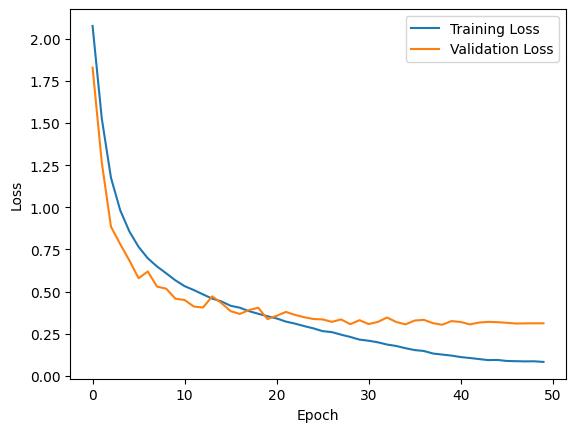

In [ ]:
# Create a list of epoch numbers
epochs = list(range(len(train_loss)))

# Plot the training loss and validation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, v_loss, label='Validation Loss')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plot
plt.show()

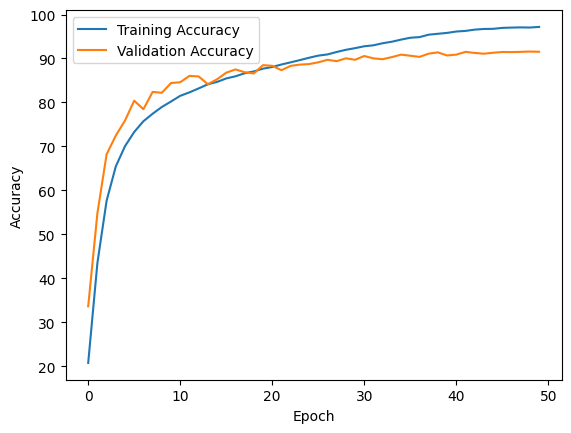

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(epochs, training_acc, label='Training Accuracy')
plt.plot(epochs, v_acc, label='Validation Accuracy')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

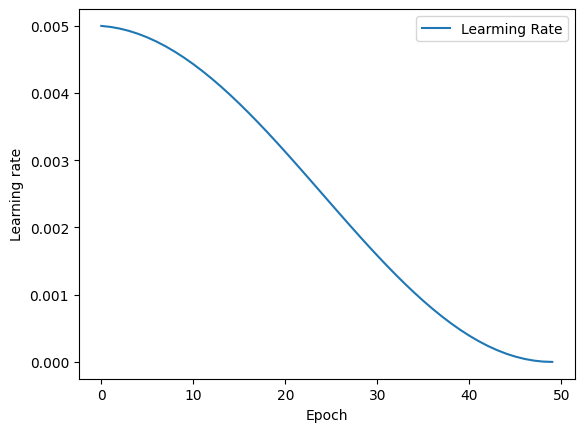

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(epochs, learn_rate, label='Learming Rate')
# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

# Show the plot
plt.show()

In [ ]:
# Create a dictionary containing all the necessary information
checkpoint = {
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'accuracy': epoch_acc,
    'loss': epoch_loss
}

# Save the checkpoint to a file
torch.save(checkpoint, path)

In [8]:
# Load the saved data
checkpoint = torch.load(path)

# Extract the model state dictionary, optimizer state dictionary, epoch number, accuracy, and loss
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
loss = checkpoint['loss']

# Load the saved state dictionaries into the model and optimizer
net.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)

# Print all parameters of the model
for name, param in net.named_parameters():
    print(name, param.shape)
print(f"Loaded checkpoint from epoch {epoch} with accuracy {accuracy}")

conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
bn1.weight torch.Size([32])
bn1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
bn2.weight torch.Size([64])
bn2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 3, 3])
conv3.bias torch.Size([128])
bn3.weight torch.Size([128])
bn3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
bn4.weight torch.Size([256])
bn4.bias torch.Size([256])
conv5.weight torch.Size([512, 256, 3, 3])
conv5.bias torch.Size([512])
bn5.weight torch.Size([512])
bn5.bias torch.Size([512])
conv6.weight torch.Size([1024, 512, 3, 3])
conv6.bias torch.Size([1024])
bn6.weight torch.Size([1024])
bn6.bias torch.Size([1024])
fc1.weight torch.Size([512, 16384])
fc1.bias torch.Size([512])
fc2.weight torch.Size([10, 512])
fc2.bias torch.Size([10])
Loaded checkpoint from epoch 50 with accuracy 97.186


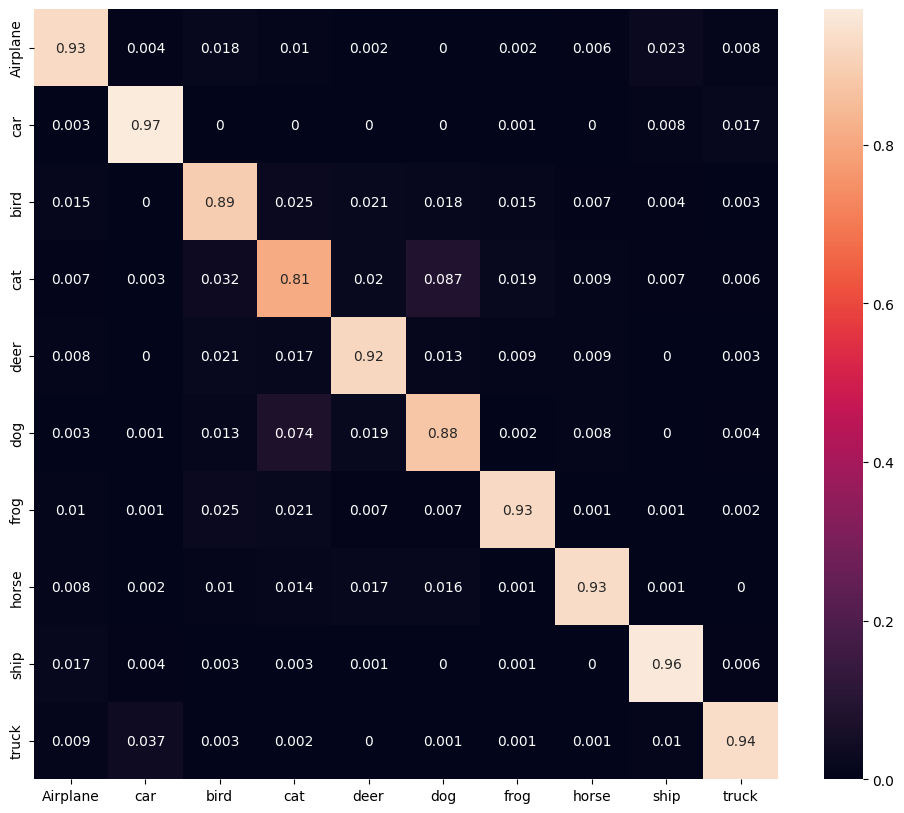

In [9]:
y_pred = []
y_true = []

# set model to eval mode and move to GPU if available
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# iterate over test data
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('outputjugal.png')